[[ 24.94003847+0.00000000e+00j  12.73268299-8.00101644e-17j
   -1.38095598-6.59184519e-15j ... -64.02389647-9.12922248e-15j
  -67.76356741-9.75391395e-15j -61.18058974-2.88788058e-15j]
 [-18.55666362-5.81663109e+01j -42.51586944-4.69129224e+01j
  -60.80795253-2.57480390e+01j ... -26.39439597+1.13082890e+02j
    6.86544434+1.23000456e+02j  41.4436393 +1.10055312e+02j]
 [-16.04755868+3.28279829e+01j -22.03971648-4.57977740e+01j
  -23.23089505-1.04141716e+02j ... -25.03391682-9.26527314e+01j
  -29.2936105 -4.09594873e+01j -31.3712619 +1.56986891e+01j]
 ...
 [ 24.73021466-5.66774723e+02j  34.94179045-3.31372917e+02j
   38.82924248-4.97842318e+01j ...   4.99619196+6.02396295e+02j
   -9.93322885+4.90736906e+02j -25.6299042 +2.81792021e+02j]
 [ 25.33720124-3.61633792e+02j  43.00958768-4.53711746e+02j
   51.93221654-4.47841562e+02j ... -30.76392977+2.66442187e+02j
  -58.45411318+4.29165358e+02j -74.0191717 +5.05315322e+02j]
 [ -6.4753501 +3.96245454e+01j  15.86720969-5.83358549e+01j
   37.7389

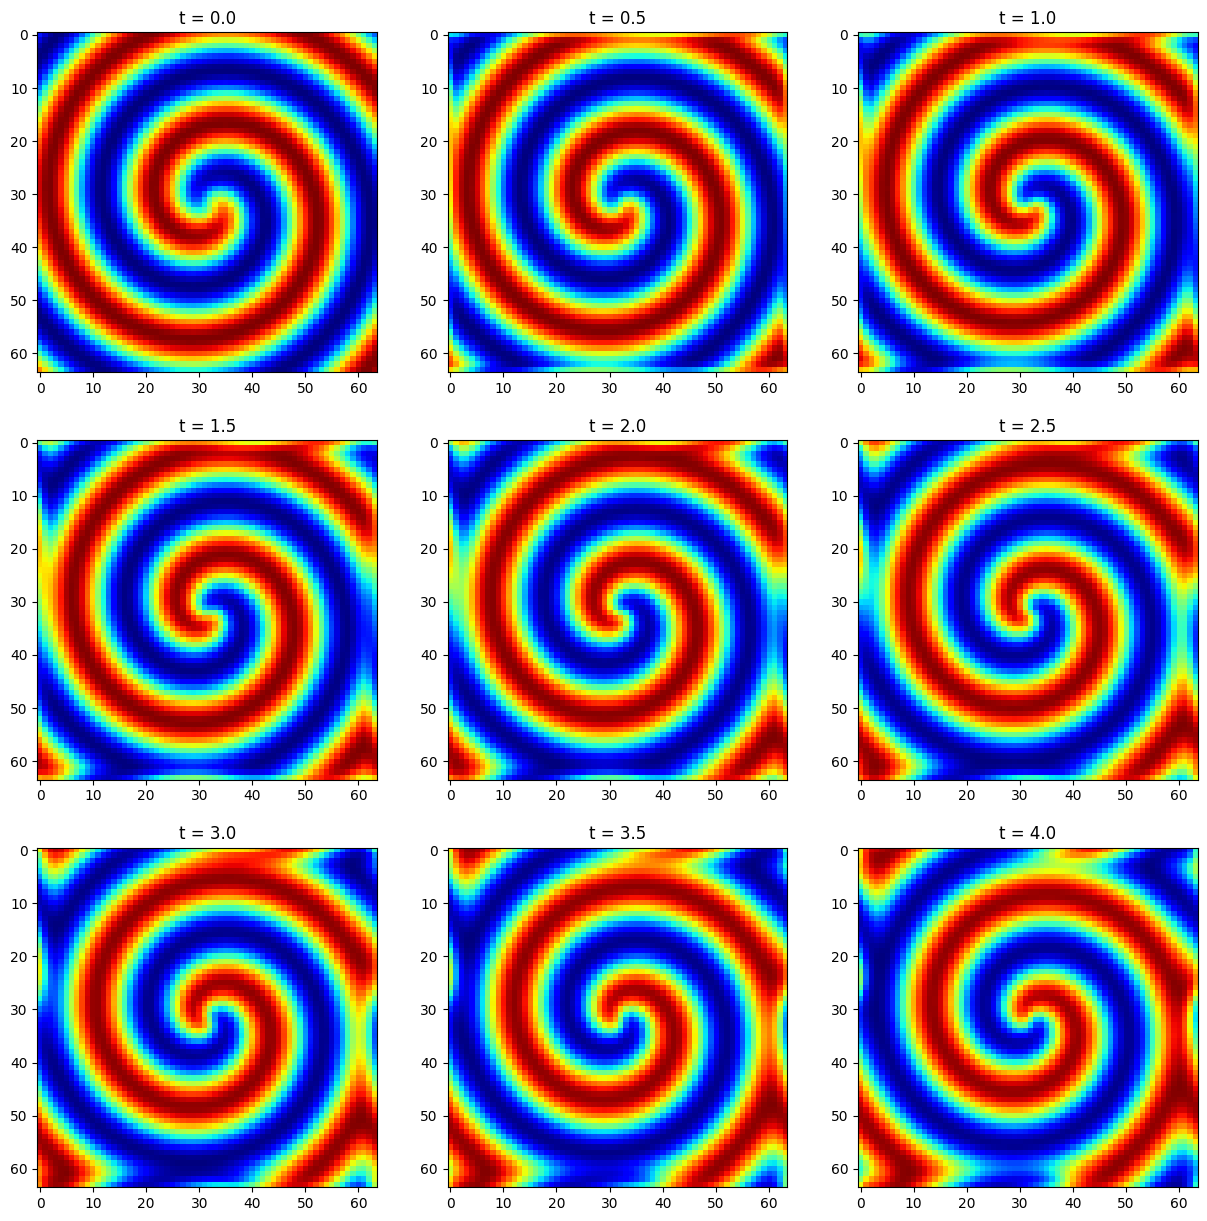

In [26]:
import numpy as np
from scipy.fft import fft2, ifft2
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Parameters
Lx, Ly = 20, 20  # Domain size
nx, ny = 64, 64  # Grid points
N = nx * ny  # Total grid points
beta = 1  # Parameter for lambda-omega
D1 = D2 = 0.1  # Diffusion coefficients
tspan = np.arange(0, 4.5, 0.5)  # Time range

# Spatial domain
x = np.linspace(-Lx/2, Lx/2, nx + 1)
x2 = x[:nx]  # Remove periodic duplicate
y = np.linspace(-Ly/2, Ly/2, ny + 1)
y2 = y[:ny]
X, Y = np.meshgrid(x2, y2)

# Initial conditions (spirals)
A = np.sqrt(X**2 + Y**2)
Theta = np.angle(X + 1j * Y)
U_init = np.tanh(A) * np.cos(Theta - A)
V_init = np.tanh(A) * np.sin(Theta - A)

Ut = fft2(U_init).reshape(N)
Vt = fft2(V_init).reshape(N)

uv_init = np.hstack([Ut, Vt])  # Flatten to 1D


# Define spectral k values for FFT
kx = (2 * np.pi / Lx) * np.concatenate([np.arange(0, nx//2), np.arange(-nx//2, 0)])
ky = (2 * np.pi / Ly) * np.concatenate([np.arange(0, ny//2), np.arange(-ny//2, 0)])
kx[0] = 1e-6  # Avoid division by zero
ky[0] = 1e-6
KX, KY = np.meshgrid(kx, ky)
K = KX**2 + KY**2  # Laplacian in Fourier space

# Lambda and Omega functions
def lambda_omega(U, V):
    A_square = U**2 + V**2
    lambda_A = 1 - A_square
    omega_A = -beta * A_square
    return lambda_A, omega_A

# Reaction-diffusion system in Fourier space
def reaction_diffusion(t, uv):
    Ut = uv[:N].reshape((ny, nx))
    Vt = uv[N:].reshape((ny, nx))
    
    U = ifft2(Ut)
    V = ifft2(Vt)
    # Reaction terms
    lambda_A, omega_A = lambda_omega(U, V)
    reaction_U = fft2(lambda_A * U - omega_A * V)
    reaction_V = fft2(omega_A * U + lambda_A * V)
    
    # Diffusion terms
    diffusion_U = -D1 * K * Ut
    diffusion_V = -D2 * K * Vt
    
    # Combine reaction and diffusion
    dU_dt = reaction_U + diffusion_U
    dV_dt = reaction_V + diffusion_V
    
    return np.hstack([dU_dt.reshape(N), dV_dt.reshape(N)])


sol = solve_ivp(
    reaction_diffusion,
    [tspan[0], tspan[-1]],
    uv_init,
    t_eval=tspan,
    method='RK45'
)

A1 = sol.y
print(A1)

#Plot
fig, ax = plt.subplots(3, 3, figsize=(15, 15))
for i, t in enumerate(tspan):
    U = ifft2(A1[:N, i].reshape((ny, nx)))
    V = ifft2(A1[N:, i].reshape((ny, nx)))
    ax[i//3, i%3].imshow(U.real, cmap='jet')
    ax[i//3, i%3].set_title(f't = {t:.1f}')

plt.show()


In [27]:
from scipy.linalg import kron
from numpy import *

# Chebychev differentiation matrix
def cheb(N):
	if N==0: 
		D = 0.; x = 1.
	else:
		n = arange(0,N+1)
		x = cos(pi*n/N).reshape(N+1,1) 
		c = (hstack(( [2.], ones(N-1), [2.]))*(-1)**n).reshape(N+1,1)
		X = tile(x,(1,N+1))
		dX = X - X.T
		D = dot(c,1./c.T)/(dX+eye(N+1))
		D -= diag(sum(D.T,axis=0))
	return D, x.reshape(N+1)

# Generate Chebychev grid and differentiation matrix
N = 30  # Grid points
D, x = cheb(N)
D[N,:] = 0
D[0,:] = 0

Dxx = np.dot(D, D) / ((20/2)**2)  # Rescale to domain size 20
y = x

N2 = (N + 1) * (N + 1)
I = np.eye(len(Dxx))
L = kron(I, Dxx) + kron(Dxx, I)  # 2D Laplacian operator

# Define the 2D spatial grid
X, Y = np.meshgrid(x, y)
X = X * (20/2)
Y = Y * (20/2)

# Spiral initial conditions
m = 1
U_init = np.tanh(np.sqrt(X**2 + Y**2)) * np.cos(m * np.angle(X + 1j * Y) - np.sqrt(X**2 + Y**2))
V_init = np.tanh(np.sqrt(X**2 + Y**2)) * np.sin(m * np.angle(X + 1j * Y) - np.sqrt(X**2 + Y**2))

UV_init = np.hstack([U_init.reshape(N2), V_init.reshape(N2)])
# Define lambda(A) and omega(A)


# Right-hand side of the ODE
def RD_2D(t, UV, D1=D1, D2=D2):
    U = UV[0:N2]
    V = UV[N2:]
    
    # Compute A
    A2 = U**2 + V**2
	
    # Compute lambda(A) and omega(A)
    lambda_A = 1 - A2
    omega_A = -beta * A2
    
    rhs_U = D1 * np.dot(L, U) + lambda_A * U - omega_A * V
    rhs_V = D2 * np.dot(L, V) + omega_A * U + lambda_A * V
    
    rhs = np.hstack([rhs_U, rhs_V])

    return rhs

# Solve the ODE
sol = solve_ivp(
    RD_2D,
    [tspan[0], tspan[-1]],
    UV_init,
    t_eval=tspan,
    method='RK45')

A2 = sol.y
print(A2)

[[ 0.70358468  0.27678435 -0.21775865 ... -0.79689015 -0.40972859
   0.07776933]
 [ 0.73241275  0.47188952  0.07344742 ... -0.96577657 -0.78500366
  -0.4261521 ]
 [ 0.81058026  0.37605887 -0.11123233 ... -0.84008598 -0.49565779
  -0.03085913]
 ...
 [ 0.58562756  0.91352592  0.97914313 ... -0.50294695 -0.84298442
  -0.97634716]
 [ 0.6808609   0.87018536  0.97997159 ... -0.16453512 -0.5878894
  -0.88455009]
 [ 0.71061143  0.96093661  0.97601586 ... -0.60413504 -0.91222169
  -0.99697897]]
